# Assignment-1: Hooli Message forum Clustering.
## Aditya Sinha

## Install & Import Pacakges

In [1]:
# !pip install wordcloud nltk

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

# sklearn KMeans
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics 
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

import plotly.graph_objects as go
import scikitplot as skplt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Import the forums dataset.
forums = pd.read_pickle("forums.pkl")
forums.head(3)

text        e0        e1  \
0                                                     0.000000  0.000000   
1  Didn't one of the early jet fighters have thes... -0.032947  0.120877   
2  I bought my HP48sx calculator a month ago, use... -0.057366  0.190520   

         e2        e3        e4        e5        e6        e7        e8  ...  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
1 -0.075873 -0.076834 -0.005793  0.006867 -0.043206 -0.026466  0.005214  ...   
2 -0.100694 -0.121314  0.073766 -0.007092 -0.047218 -0.166004  0.072910  ...   

       e290     e291      e292      e293      e294      e295      e296  \
0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
1 -0.207951  0.01521  0.031759 -0.070944  0.075598 -0.020428 -0.045896   
2 -0.219416 -0.00675 -0.009741 -0.039333 -0.042368 -0.059894 -0.006622   

       e297      e298      e299  
0  0.000000  0.000000  0.000000  
1 -0.004107  0.052477  0.120896  
2 -0.090851  0.045055  0.062297  

[3 rows x 301 columns]

In [3]:
# number of columns
len(forums.columns)

301

## Data Cleaning, and Preprocessing

In [4]:
# Check to see if there is any identicle column
for x in forums:
    for y in forums:
        if(forums[x].equals(forums[y]) and x!=y):
            print(x,y)
    

In [5]:
for col in forums.columns.values.tolist():
  if(forums[col].dtypes == "object"):
    forums[col] = forums[col].str.strip()

# replace field that's entirely space (or empty) with NaN
forums = forums.replace('', np.nan)  

In [6]:
forums.shape

(2362, 301)

In [7]:
# Check for duplicates
forums.duplicated().sum()

58

In [8]:
forums.drop_duplicates(inplace=True)

In [9]:
# Check for null values
forums.isna().sum()
forums.isna().sum().sum()

1

In [10]:
forums.dropna(inplace=True)

In [11]:
forums.head(3)

text        e0        e1  \
1  Didn't one of the early jet fighters have thes... -0.032947  0.120877   
2  I bought my HP48sx calculator a month ago, use... -0.057366  0.190520   
3  I would guess not.  Dr. Neil Gehrels of CGRO i... -0.032504  0.165183   

         e2        e3        e4        e5        e6        e7        e8  ...  \
1 -0.075873 -0.076834 -0.005793  0.006867 -0.043206 -0.026466  0.005214  ...   
2 -0.100694 -0.121314  0.073766 -0.007092 -0.047218 -0.166004  0.072910  ...   
3 -0.101052 -0.018943  0.060833  0.039176 -0.045718 -0.111591 -0.028218  ...   

       e290      e291      e292      e293      e294      e295      e296  \
1 -0.207951  0.015210  0.031759 -0.070944  0.075598 -0.020428 -0.045896   
2 -0.219416 -0.006750 -0.009741 -0.039333 -0.042368 -0.059894 -0.006622   
3 -0.157370  0.041819  0.030946 -0.029487  0.051459  0.040399 -0.025781   

       e297      e298      e299  
1 -0.004107  0.052477  0.120896  
2 -0.090851  0.045055  0.062297  
3 -0.011279  0.002328  0.011600  

[3 rows x 301 columns]

In [12]:
forums.dtypes

text     object
e0      float64
e1      float64
e2      float64
e3      float64
         ...   
e295    float64
e296    float64
e297    float64
e298    float64
e299    float64
Length: 301, dtype: object

In [13]:
forums.describe().T

count      mean       std       min       25%       50%       75%  \
e0    2303.0 -0.037338  0.053699 -0.622081 -0.061756 -0.034638 -0.008708   
e1    2303.0  0.166890  0.057020 -0.196960  0.134120  0.165717  0.198865   
e2    2303.0 -0.117869  0.067583 -0.490025 -0.160776 -0.122618 -0.077969   
e3    2303.0 -0.061495  0.051207 -0.393122 -0.087674 -0.059321 -0.031117   
e4    2303.0  0.081117  0.053203 -0.163500  0.048272  0.079026  0.112358   
...      ...       ...       ...       ...       ...       ...       ...   
e295  2303.0 -0.014446  0.050496 -0.352770 -0.040381 -0.012272  0.014695   
e296  2303.0 -0.044039  0.045675 -0.562870 -0.069640 -0.044689 -0.018464   
e297  2303.0 -0.071159  0.048826 -0.581665 -0.098201 -0.071217 -0.042779   
e298  2303.0  0.001852  0.058199 -0.501450 -0.027014  0.005330  0.034960   
e299  2303.0  0.073253  0.056475 -0.338469  0.039604  0.071772  0.108843   

           max  
e0    0.197311  
e1    0.533470  
e2    0.363830  
e3    0.322405  
e4    0.390160  
...        ...  
e295  0.263430  
e296  0.237821  
e297  0.179845  
e298  0.226430  
e299  0.269688  

[300 rows x 8 columns]

### Clean and Tokenize text field

In [14]:
stops = set(stopwords.words("english"))

In [15]:
def clean_content(text):
    #Converting text to lowercase characters
    text = text.lower()
    #Removing HTML tags
    text = re.sub(r'\<[^<>]*\>','', text) 
    #Removing any character which does not match to letter,digit or underscore
    text = re.sub(r'^\W+|\W+$',' ', text)
    #Removing space,newline,tab
    text = re.sub(r'\s',' ',text)
    #Removing punctuation
    text = re.sub(r'[^a-zA-Z0-9]',' ',text)
    # Remove any numbers
    text = re.sub(r'[0-9]+', '', text)
    #Tokenizing data
    text = word_tokenize(text)
    #Removing stopwords
    text = [i for i in text if i not in stops]
    return(text)

In [16]:
forums['text'] = forums['text'].apply(lambda x: clean_content(x))

In [17]:
frms = forums.copy()
frms = frms.set_index("text")

In [18]:
frms.head(2)

e0        e1  \
text                                                                     
[one, early, jet, fighters, also, think, german... -0.032947  0.120877   
[bought, hpsx, calculator, month, ago, used, pu... -0.057366  0.190520   

                                                          e2        e3  \
text                                                                     
[one, early, jet, fighters, also, think, german... -0.075873 -0.076834   
[bought, hpsx, calculator, month, ago, used, pu... -0.100694 -0.121314   

                                                          e4        e5  \
text                                                                     
[one, early, jet, fighters, also, think, german... -0.005793  0.006867   
[bought, hpsx, calculator, month, ago, used, pu...  0.073766 -0.007092   

                                                          e6        e7  \
text                                                                     
[one, early, jet, fighters, also, think, german... -0.043206 -0.026466   
[bought, hpsx, calculator, month, ago, used, pu... -0.047218 -0.166004   

                                                          e8        e9  ...  \
text                                                                    ...   
[one, early, jet, fighters, also, think, german...  0.005214  1.907945  ...   
[bought, hpsx, calculator, month, ago, used, pu...  0.072910  1.741046  ...   

                                                        e290     e291  \
text                                                                    
[one, early, jet, fighters, also, think, german... -0.207951  0.01521   
[bought, hpsx, calculator, month, ago, used, pu... -0.219416 -0.00675   

                                                        e292      e293  \
text                                                                     
[one, early, jet, fighters, also, think, german...  0.031759 -0.070944   
[bought, hpsx, calculator, month, ago, used, pu... -0.009741 -0.039333   

                                                        e294      e295  \
text                                                                     
[one, early, jet, fighters, also, think, german...  0.075598 -0.020428   
[bought, hpsx, calculator, month, ago, used, pu... -0.042368 -0.059894   

                                                        e296      e297  \
text                                                                     
[one, early, jet, fighters, also, think, german... -0.045896 -0.004107   
[bought, hpsx, calculator, month, ago, used, pu... -0.006622 -0.090851   

                                                        e298      e299  
text                                                                    
[one, early, jet, fighters, also, think, german...  0.052477  0.120896  
[bought, hpsx, calculator, month, ago, used, pu...  0.045055  0.062297  

[2 rows x 300 columns]

In [19]:
frms.shape

(2303, 300)

## Dimensionality Reduction

<AxesSubplot:>

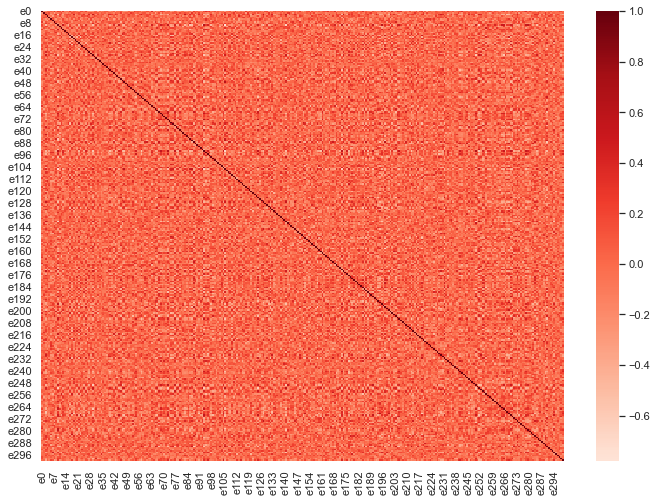

In [20]:
# Heatmap to see correlation
sns.set(rc={'figure.figsize':(11.7,8.27)})
frm_corr = frms.corr()
sns.heatmap(frm_corr, cmap="Reds", center=0)

In [21]:
# PCA
pca = PCA()
pcs = pca.fit_transform(frms)
var_exp_ratio = pca.explained_variance_ratio_

C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


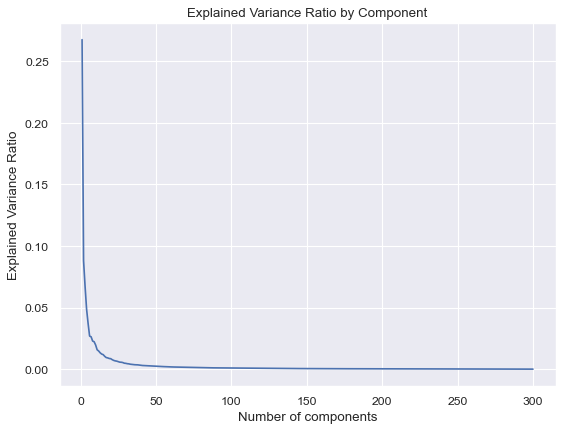

In [22]:
figure(figsize=(8, 6), dpi=80)
plt.title("Explained Variance Ratio by Component")
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
sns.lineplot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.show()

In [23]:
fig = go.Figure(data=go.Scatter(x=list(range(1,len(var_exp_ratio)+1)), y=np.cumsum(var_exp_ratio)))
fig.update_layout(
    title="Cum. Explained Variance Ratio by Component",
    xaxis_title="Cum. Explained Variance Ratio",
    yaxis_title="Number of components",
)
fig.show()

In [24]:
comp_frms = pcs[:,:30]
comp_frms.shape

(2303, 30)

In [25]:
frms_pca = pd.DataFrame(comp_frms, columns=["c"+str(x)for x in range(1,31)], index=frms.index)
frms_pca.sample(2)

c1        c2  \
text                                                                     
[roland, hs, synthplus, voice, polyphonic, full...  0.927598 -0.383456   
[hello, searching, rendering, software, develop... -0.211803 -0.037572   

                                                          c3        c4  \
text                                                                     
[roland, hs, synthplus, voice, polyphonic, full... -0.210669 -0.138020   
[hello, searching, rendering, software, develop... -0.478198 -0.251571   

                                                          c5        c6  \
text                                                                     
[roland, hs, synthplus, voice, polyphonic, full... -0.057042 -0.211781   
[hello, searching, rendering, software, develop... -0.393708 -0.031940   

                                                          c7        c8  \
text                                                                     
[roland, hs, synthplus, voice, polyphonic, full... -0.147136 -0.211520   
[hello, searching, rendering, software, develop... -0.026932  0.110172   

                                                          c9       c10  ...  \
text                                                                    ...   
[roland, hs, synthplus, voice, polyphonic, full...  0.176946 -0.116811  ...   
[hello, searching, rendering, software, develop...  0.205744  0.086663  ...   

                                                         c21       c22  \
text                                                                     
[roland, hs, synthplus, voice, polyphonic, full... -0.013816 -0.211856   
[hello, searching, rendering, software, develop... -0.174155 -0.032228   

                                                         c23       c24  \
text                                                                     
[roland, hs, synthplus, voice, polyphonic, full... -0.216376  0.081112   
[hello, searching, rendering, software, develop... -0.021194  0.062702   

                                                         c25       c26  \
text                                                                     
[roland, hs, synthplus, voice, polyphonic, full... -0.096872  0.093947   
[hello, searching, rendering, software, develop... -0.105975  0.011321   

                                                         c27       c28  \
text                                                                     
[roland, hs, synthplus, voice, polyphonic, full...  0.081632 -0.065446   
[hello, searching, rendering, software, develop...  0.163065 -0.058430   

                                                         c29       c30  
text                                                                    
[roland, hs, synthplus, voice, polyphonic, full...  0.042837  0.062787  
[hello, searching, rendering, software, develop... -0.051122  0.028293  

[2 rows x 30 columns]

## Hierarchical clustering

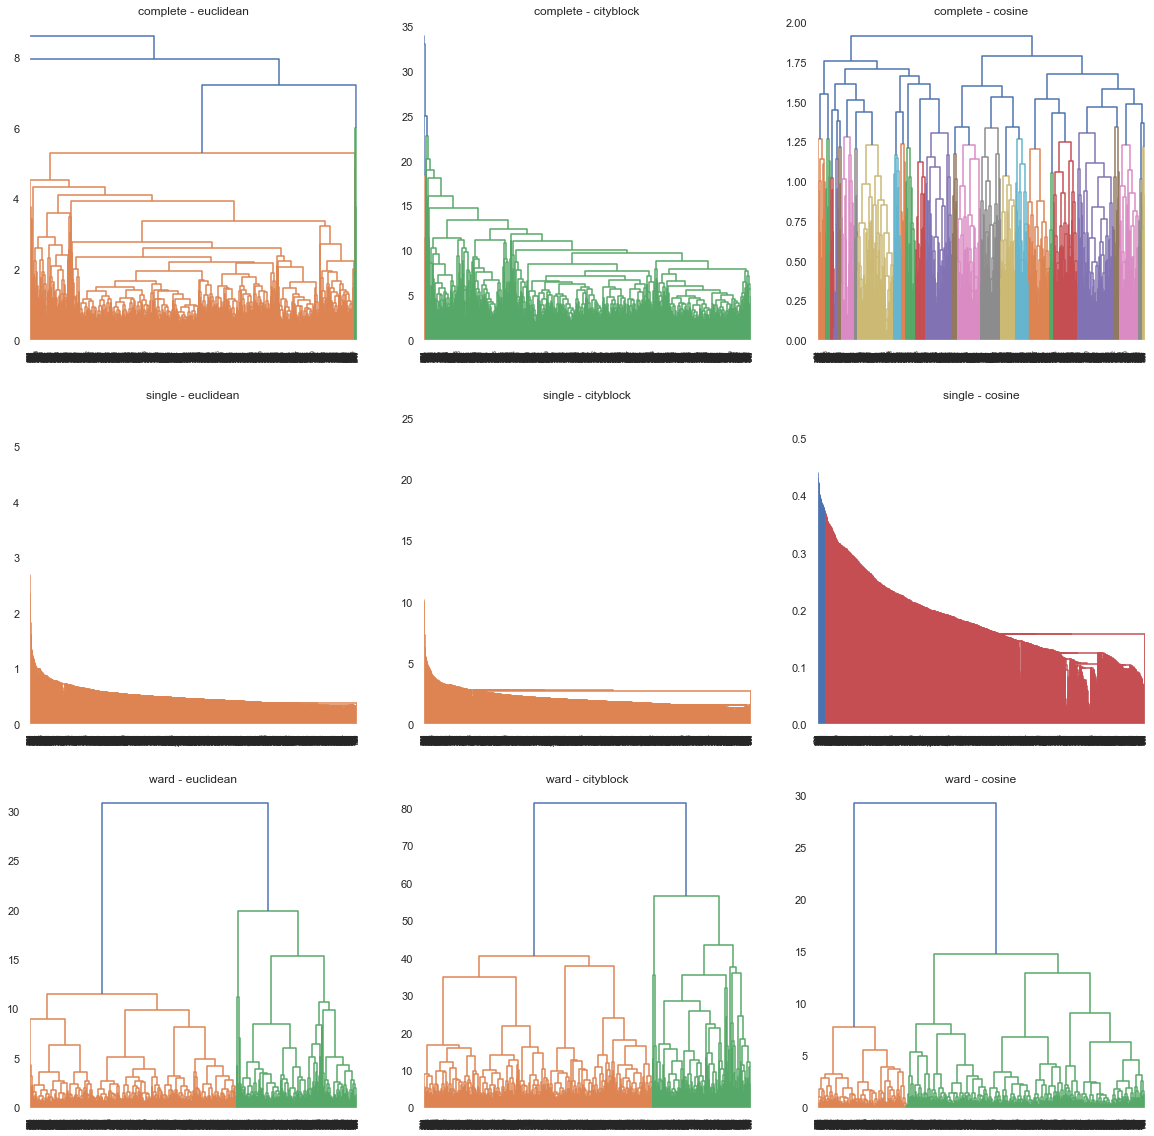

In [26]:
plt.figure(figsize=(20,20))

method = ['complete', 'single', 'ward']
metric = ['euclidean', 'cityblock', 'cosine']
linkage_dict = {}

ind = 0
for i,mtd in enumerate(method):
    for j,met,  in enumerate(metric):
        d0=pdist(frms_pca, metric=met)
        ind = ind+1
        link = linkage(d0,method=mtd)
        linkage_dict[mtd +" - " +met] = link
        plt.subplot(3,3, ind)
        plt.title(mtd +" - " +met)
        dendrogram(link)
  
plt.show()    


In [27]:
corr = {}
for key,val in linkage_dict.items():
    cop = cophenet(linkage_dict[key])
    corr[key] = np.corrcoef(d0, cop)[0,1]
    
corr    

{'complete - euclidean': 0.2821885041485379,
 'complete - cityblock': 0.31749392640824575,
 'complete - cosine': 0.5711061359808948,
 'single - euclidean': 0.11482550962172904,
 'single - cityblock': 0.10194438474251505,
 'single - cosine': 0.029123425780942496,
 'ward - euclidean': 0.632448918367717,
 'ward - cityblock': 0.5887732435855317,
 'ward - cosine': 0.620581189875884}

C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



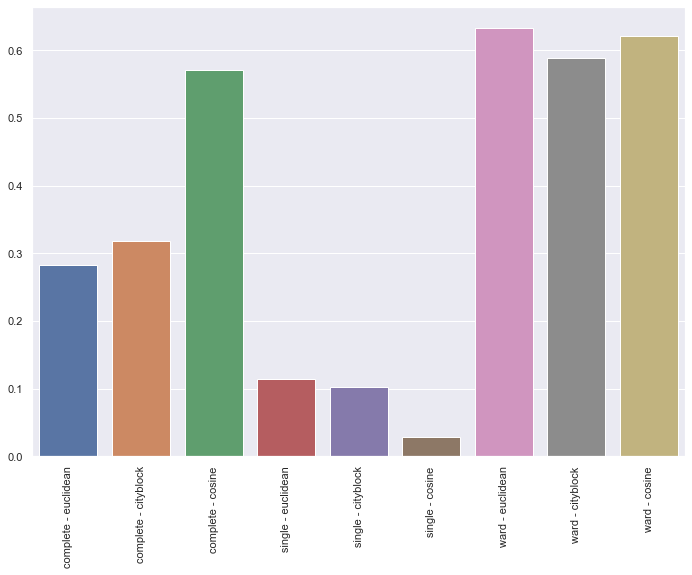

In [28]:
bar_plot = sns.barplot(list(corr.keys()),list(corr.values()))
plt.xticks(rotation=90)
plt.show()

In [29]:
silhouette_her = []
for i in range(2,10):
    hc_labs = fcluster(linkage_dict["ward - euclidean"], i, criterion="maxclust")
    silhouette_her.append(metrics.silhouette_score(frms_pca, hc_labs))


C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'The Silhouette Method'}, xlabel='Average Silhouette Width', ylabel='Silhouette'>

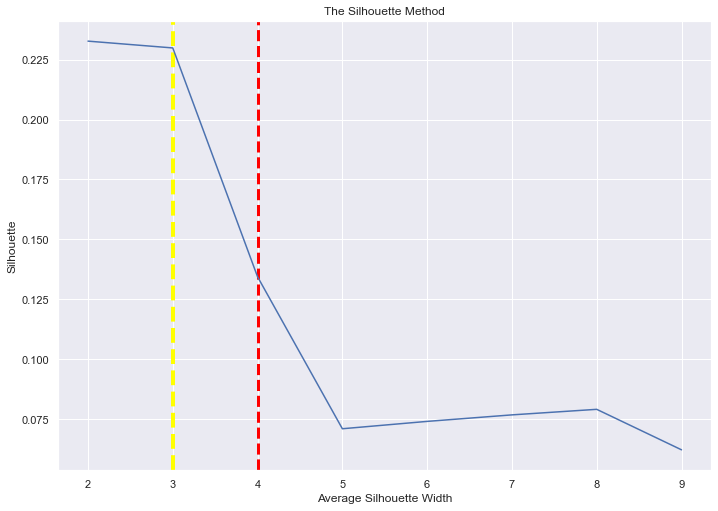

In [30]:
plt.title('The Silhouette Method')
plt.xlabel('Average Silhouette Width')
plt.ylabel('Silhouette')
plt.axvline(x=4, c='red', lw=3, linestyle='dashed')
plt.axvline(x=3, c='yellow', lw=4, linestyle='dashed')
sns.lineplot(range(2,10),silhouette_her)

In [31]:
hc_labs_3 = fcluster(linkage_dict["ward - euclidean"], 3, criterion="maxclust")
forums['hie_cluster_3'] = hc_labs_3

In [32]:
hc_labs_4 = fcluster(linkage_dict["ward - euclidean"], 4, criterion="maxclust")
forums['hie_cluster_4'] = hc_labs_4

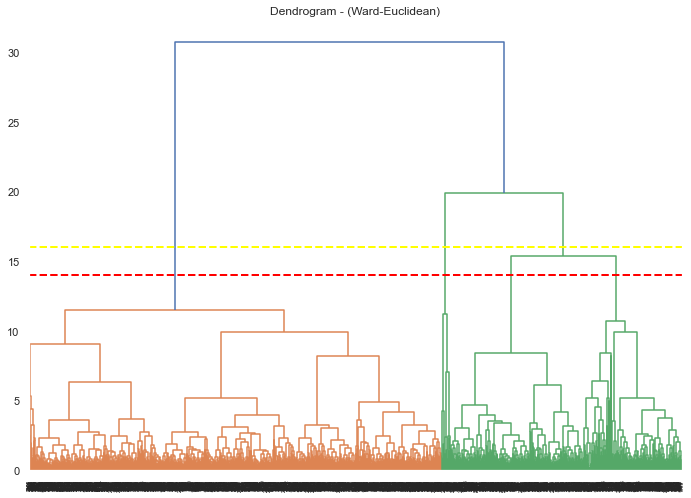

In [33]:
d0=pdist(frms_pca, metric="euclidean")
link = linkage(d0,method="ward")
plt.title("Dendrogram - (Ward-Euclidean)")
dendrogram(link)
plt.axhline(y=14, c='red', lw=2, linestyle='dashed')
plt.axhline(y=16, c='yellow', lw=2, linestyle='dashed')
plt.show()

## K-Mean Clustering

In [34]:
inertia = []
silhouette = []
for i in range(2,10):
    kmeans = KMeans(i, random_state=0)
    kmeans.fit(frms_pca)
    kmeans_lab = kmeans.predict(frms_pca)
    inertia.append(kmeans.inertia_)
    silhouette.append(metrics.silhouette_score(frms_pca, kmeans_lab))

C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



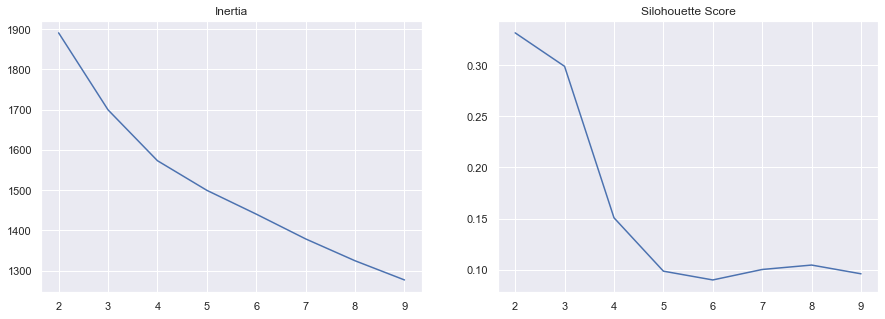

In [35]:
plt.figure(figsize=(15,5))


plt.subplot(1, 2, 1)
plt.title("Inertia")
sns.lineplot(range(2,10), inertia)

plt.subplot(1, 2, 2)
plt.title("Silohouette Score")
sns.lineplot(range(2,10), silhouette)

plt.show()

In [36]:
k3 = KMeans(3, random_state=0)
k3.fit(frms_pca)
k3_labs = k3.predict(frms_pca)
forums["kmean_cluster_3"] = k3_labs

In [37]:
k4 = KMeans(4, random_state=0)
k4.fit(frms_pca)
k4_labs = k4.predict(frms_pca)
forums["kmean_cluster_4"] = k4_labs

In [38]:
frm_cluster = forums[["hie_cluster_3", "hie_cluster_4", "kmean_cluster_3", "kmean_cluster_4"]]
counts = frm_cluster.apply(pd.value_counts)
counts

hie_cluster_3  hie_cluster_4  kmean_cluster_3  kmean_cluster_4
0            NaN            NaN           1677.0           1256.0
1         1458.0         1458.0            595.0            287.0
2           31.0           31.0             31.0             31.0
3          814.0          467.0              NaN            729.0
4            NaN          347.0              NaN              NaN

In [39]:
print(forums['hie_cluster_3'].value_counts(normalize=True) * 100)
print(forums['hie_cluster_4'].value_counts(normalize=True) * 100)
print(forums['kmean_cluster_3'].value_counts(normalize=True) * 100)
print(forums['kmean_cluster_4'].value_counts(normalize=True) * 100)

1    63.308728
3    35.345202
2     1.346070
Name: hie_cluster_3, dtype: float64
1    63.308728
3    20.277898
4    15.067304
2     1.346070
Name: hie_cluster_4, dtype: float64
0    72.818063
1    25.835866
2     1.346070
Name: kmean_cluster_3, dtype: float64
0    54.537560
3    31.654364
1    12.462006
2     1.346070
Name: kmean_cluster_4, dtype: float64


<AxesSubplot:>

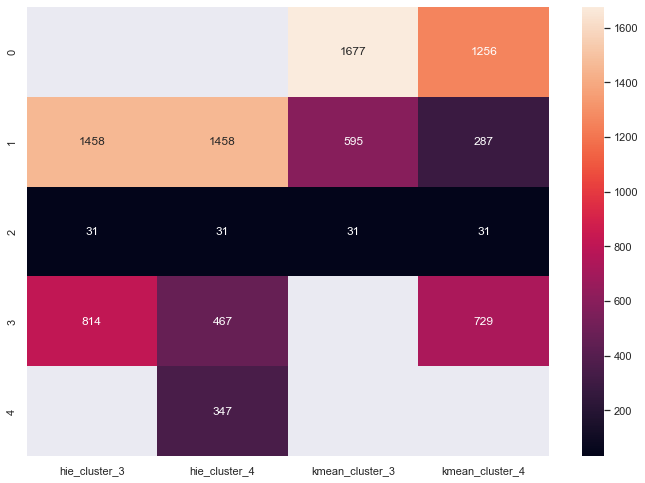

In [40]:
sns.heatmap(counts, annot=True, fmt='g')

<AxesSubplot:title={'center':'Silhouette Analysis 3 K-Mean Cluster'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

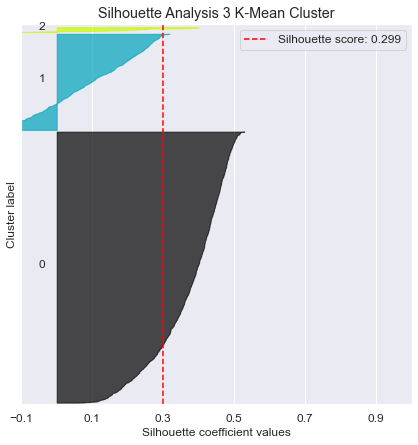

In [41]:
skplt.metrics.plot_silhouette(frms_pca, k3_labs, figsize=(7,7), title="Silhouette Analysis 3 K-Mean Cluster")

<AxesSubplot:title={'center':'Silhouette Analysis 4 K-Mean Cluster'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

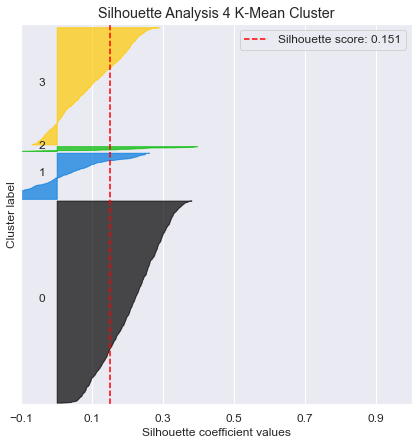

In [42]:
skplt.metrics.plot_silhouette(frms_pca, k4_labs, figsize=(7,7), title="Silhouette Analysis 4 K-Mean Cluster")

<AxesSubplot:title={'center':'Silhouette Analysis 3 Hierarchical Cluster'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

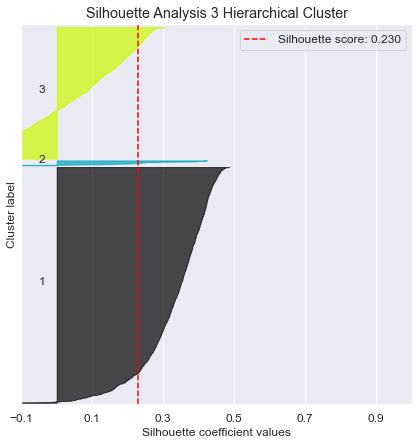

In [43]:
skplt.metrics.plot_silhouette(frms_pca, hc_labs_3, figsize=(7,7),  title="Silhouette Analysis 3 Hierarchical Cluster")

<AxesSubplot:title={'center':'Silhouette Analysis 4 Hierarchical Cluster'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

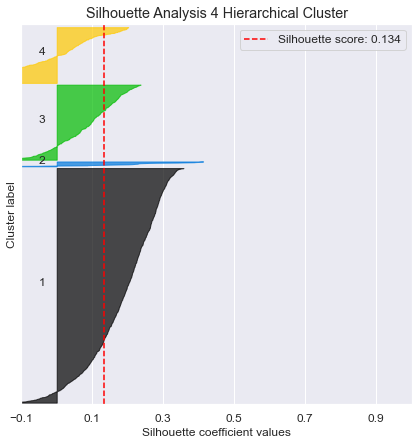

In [44]:
skplt.metrics.plot_silhouette(frms_pca, hc_labs_4, figsize=(7,7), title="Silhouette Analysis 4 Hierarchical Cluster")

## Analysis and Conclusion

In [45]:
forums.sample(3)

text        e0        e1  \
1700  [looking, database, called, micro, world, data... -0.037686  0.166504   
1759  [maxtor, product, specification, oem, manual, ...  0.016619  0.214114   
2208  [hi, name, rahul, ms, usu, loganmy, query, hp,...  0.018933  0.222621   

            e2        e3        e4        e5        e6        e7        e8  \
1700 -0.221401 -0.050103  0.113767  0.065780  0.003562 -0.200575 -0.062581   
1759 -0.057161 -0.010436  0.149657 -0.038022  0.003031 -0.113086 -0.030234   
2208 -0.137834 -0.079819  0.069906 -0.026262  0.011784 -0.102283 -0.048430   

      ...      e294      e295      e296      e297      e298      e299  \
1700  ...  0.073276 -0.058299 -0.057423 -0.088352 -0.027920  0.125306   
1759  ... -0.006122 -0.033158 -0.050302 -0.027075  0.015269 -0.031061   
2208  ...  0.014435 -0.000116 -0.066608 -0.071818  0.002048  0.144159   

      hie_cluster_3  hie_cluster_4  kmean_cluster_3  kmean_cluster_4  
1700              1              1                0                0  
1759              3              4                1                3  
2208              1              1                0                3  

[3 rows x 305 columns]

### hie_cluster_3

In [46]:
grouped_df_hie_3 = forums.copy()
grouped_df_hie_3 = grouped_df_hie_3.groupby('hie_cluster_3').agg({'text': 'sum'}).reset_index()

In [47]:
grouped_df_hie_3.head()

hie_cluster_3                                               text
0              1  [one, early, jet, fighters, also, think, germa...
1              2  [run, spacenews, views, stareach, bbs, localop...
2              3  [bought, hpsx, calculator, month, ago, used, p...

In [48]:
from collections import Counter

for i in range(len(grouped_df_hie_3)):
    print(grouped_df_hie_3['hie_cluster_3'][i])
    words = grouped_df_hie_3['text'][i]
    most_common_words= [word for word, word_count in Counter(words).most_common(100)]
    print(most_common_words)
    
    

1
['would', 'one', 'like', 'get', 'know', 'think', 'also', 'space', 'time', 'team', 'game', 'could', 'good', 'much', 'well', 'jpeg', 'year', 'use', 'go', 'people', 'even', 'see', 'first', 'need', 'two', 'anyone', 'image', 'season', 'play', 'new', 'hockey', 'back', 'games', 'make', 'may', 'way', 'last', 'thanks', 'want', 'please', 'years', 'got', 'file', 'bit', 'better', 'since', 'etc', 'program', 'graphics', 'still', 'many', 'right', 'us', 'files', 'find', 'players', 'say', 'work', 'might', 'going', 'really', 'points', 'something', 'around', 'said', 'let', 'x', 'best', 'e', 'lot', 'point', 'software', 'used', 'problem', 'gif', 'system', 'probably', 'take', 'made', 'color', 'look', 'mail', 'things', 'format', 'great', 'little', 'sure', 'nhl', 'using', 'never', 'actually', 'another', 'images', 'long', 'enough', 'c', 'looking', 'available', 'maybe', 'line']
2
['university', 'one', 'edu', 'siggraph', 'computer', 'books', 'vinge', 'material', 'form', 'send', 'information', 'fax', 'email', '

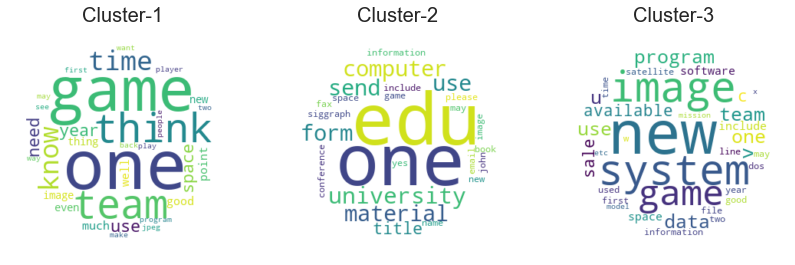

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 14], facecolor = None)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(" ".join(grouped_df_hie_3['text'][0]))

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title('Cluster-1',fontsize=20)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(" ".join(grouped_df_hie_3['text'][1]))

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Cluster-2',fontsize=20);

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(" ".join(grouped_df_hie_3['text'][2]))

ax3.axis("off")
ax3.imshow(wc3, interpolation="bilinear")
ax3.set_title('Cluster-3',fontsize=20)

plt.show()

### hie_cluster_4

In [50]:
grouped_df_hie_4 = forums.copy()
grouped_df_hie_4 = grouped_df_hie_4.groupby('hie_cluster_4').agg({'text': 'sum'}).reset_index()

In [51]:
from collections import Counter

for i in range(len(grouped_df_hie_4)):
    print(grouped_df_hie_4['hie_cluster_4'][i])
    words = grouped_df_hie_4['text'][i]
    most_common_words= [word for word, word_count in Counter(words).most_common(100)]
    print(most_common_words)

1
['would', 'one', 'like', 'get', 'know', 'think', 'also', 'space', 'time', 'team', 'game', 'could', 'good', 'much', 'well', 'jpeg', 'year', 'use', 'go', 'people', 'even', 'see', 'first', 'need', 'two', 'anyone', 'image', 'season', 'play', 'new', 'hockey', 'back', 'games', 'make', 'may', 'way', 'last', 'thanks', 'want', 'please', 'years', 'got', 'file', 'bit', 'better', 'since', 'etc', 'program', 'graphics', 'still', 'many', 'right', 'us', 'files', 'find', 'players', 'say', 'work', 'might', 'going', 'really', 'points', 'something', 'around', 'said', 'let', 'x', 'best', 'e', 'lot', 'point', 'software', 'used', 'problem', 'gif', 'system', 'probably', 'take', 'made', 'color', 'look', 'mail', 'things', 'format', 'great', 'little', 'sure', 'nhl', 'using', 'never', 'actually', 'another', 'images', 'long', 'enough', 'c', 'looking', 'available', 'maybe', 'line']
2
['university', 'one', 'edu', 'siggraph', 'computer', 'books', 'vinge', 'material', 'form', 'send', 'information', 'fax', 'email', '

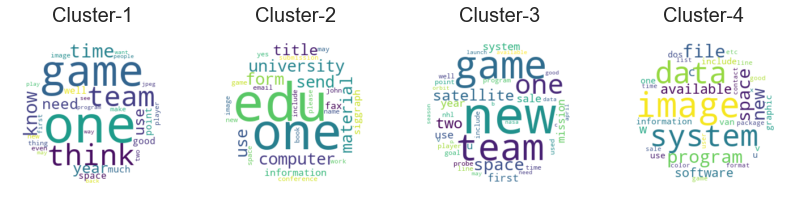

In [52]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[14, 14], facecolor = None)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(" ".join(grouped_df_hie_4['text'][0]))

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title('Cluster-1',fontsize=20)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(" ".join(grouped_df_hie_4['text'][1]))

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Cluster-2',fontsize=20)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(" ".join(grouped_df_hie_4['text'][2]))

ax3.axis("off")
ax3.imshow(wc3, interpolation="bilinear")
ax3.set_title('Cluster-3',fontsize=20)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(" ".join(grouped_df_hie_4['text'][3]))

ax4.axis("off")
ax4.imshow(wc3, interpolation="bilinear")
ax4.set_title('Cluster-4',fontsize=20)

plt.show()

### K_Mean_3

In [53]:
grouped_df_k_mean_3 = forums.copy()
grouped_df_k_mean_3 = grouped_df_k_mean_3.groupby('kmean_cluster_3').agg({'text': 'sum'}).reset_index()

In [54]:
for i in range(len(grouped_df_k_mean_3)):
    print(grouped_df_k_mean_3['kmean_cluster_3'][i])
    words = grouped_df_k_mean_3['text'][i]
    most_common_words= [word for word, word_count in Counter(words).most_common(100)]
    print(most_common_words)

0
['would', 'one', 'space', 'like', 'get', 'also', 'know', 'time', 'think', 'team', 'game', 'first', 'could', 'good', 'well', 'year', 'use', 'new', 'much', 'two', 'go', 'people', 'need', 'even', 'see', 'jpeg', 'may', 'make', 'season', 'please', 'games', 'years', 'anyone', 'back', 'program', 'image', 'way', 'play', 'last', 'launch', 'hockey', 'thanks', 'got', 'since', 'system', 'want', 'us', 'better', 'used', 'many', 'nasa', 'bit', 'etc', 'graphics', 'e', 'file', 'still', 'software', 'find', 'point', 'x', 'right', 'best', 'work', 'might', 'made', 'data', 'going', 'points', 'players', 'let', 'really', 'using', 'around', 'said', 'take', 'say', 'looking', 'problem', 'mail', 'lot', 'great', 'earth', 'something', 'another', 'look', 'c', 'power', 'images', 'files', 'next', 'moon', 'little', 'nhl', 'edu', 'probably', 'orbit', 'high', 'things', 'line']
1
['space', 'x', 'new', 'edu', 'p', 'image', 'data', 'graphics', 'e', 'w', 'available', 'also', 'c', 'st', 'period', 'nasa', 'vs', 'dos', 'pts',

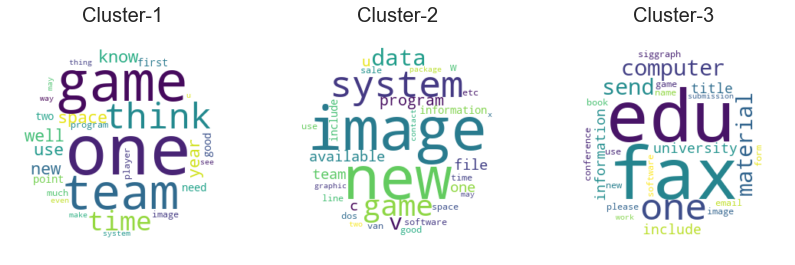

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 14], facecolor = None)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(" ".join(grouped_df_k_mean_3['text'][0]))

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title('Cluster-1',fontsize=20)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(" ".join(grouped_df_k_mean_3['text'][1]))

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Cluster-2',fontsize=20);

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(" ".join(grouped_df_k_mean_3['text'][2]))

ax3.axis("off")
ax3.imshow(wc3, interpolation="bilinear")
ax3.set_title('Cluster-3',fontsize=20)

plt.show()

### K_Mean_4

In [56]:
grouped_df_k_mean_4 = forums.copy()
grouped_df_k_mean_4 = grouped_df_k_mean_4.groupby('kmean_cluster_4').agg({'text': 'sum'}).reset_index()

In [57]:
for i in range(len(grouped_df_k_mean_4)):
    print(grouped_df_k_mean_4['kmean_cluster_4'][i])
    words = grouped_df_k_mean_4['text'][i]
    most_common_words= [word for word, word_count in Counter(words).most_common(100)]
    print(most_common_words)

0
['would', 'one', 'like', 'get', 'think', 'know', 'team', 'game', 'time', 'could', 'space', 'good', 'also', 'year', 'much', 'people', 'go', 'well', 'season', 'play', 'even', 'hockey', 'anyone', 'back', 'first', 'games', 'two', 'see', 'need', 'last', 'got', 'make', 'way', 'years', 'new', 'please', 'since', 'thanks', 'use', 'want', 'us', 'points', 'right', 'may', 'better', 'still', 'players', 'said', 'going', 'say', 'really', 'something', 'might', 'nhl', 'many', 'lot', 'made', 'best', 'take', 'point', 'little', 'find', 'program', 'let', 'probably', 'problem', 'sure', 'great', 'around', 'flyers', 'e', 'things', 'bit', 'enough', 'never', 'etc', 'actually', 'someone', 'work', 'maybe', 'another', 'looking', 'long', 'look', 'money', 'next', 'graphics', 'league', 'moon', 'end', 'used', 'nasa', 'mail', 'thought', 'give', 'post', 'system', 'big', 'thing', 'goal']
1
['p', 'new', 'x', 'edu', 'pts', 'st', 'period', 'vs', 'w', 'la', 'e', 'dos', 'c', 'hockey', 'team', 'space', 'g', 'graphics', 'van'

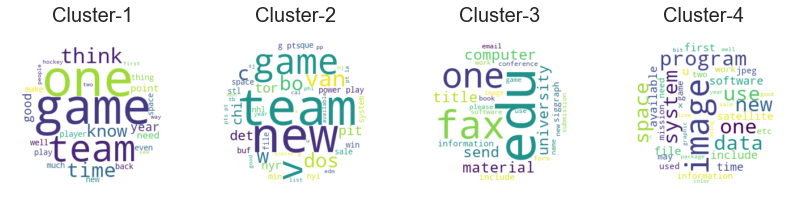

In [58]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[14, 14], facecolor = None)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(" ".join(grouped_df_k_mean_4['text'][0]))

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title('Cluster-1',fontsize=20)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(" ".join(grouped_df_k_mean_4['text'][1]))

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Cluster-2',fontsize=20)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(" ".join(grouped_df_k_mean_4['text'][2]))

ax3.axis("off")
ax3.imshow(wc3, interpolation="bilinear")
ax3.set_title('Cluster-3',fontsize=20)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(" ".join(grouped_df_k_mean_4['text'][3]))

ax4.axis("off")
ax4.imshow(wc3, interpolation="bilinear")
ax4.set_title('Cluster-4',fontsize=20)

plt.show()